In [1]:
import pandas as pd


In [2]:
df = pd.read_csv("paysimdata.csv")

In [3]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df_clean = df.copy()

In [6]:
# 1. Rename columns
df_clean = df_clean.rename(columns={
    "step": "timestamp",
    "type": "transaction_type",
    "nameOrig": "origin_account",
    "nameDest": "destination_account",
    "isFraud": "is_fraud"
})

In [7]:
# 2. Drop internal balance columns

df_clean = df_clean.drop(columns=[
    "oldbalanceOrg",
    "newbalanceOrig",
    "oldbalanceDest",
    "newbalanceDest",
    "isFlaggedFraud"
])

In [9]:
# 3. Create transaction_id
import numpy as np

df_clean["transaction_id"] = np.arange(1, len(df_clean) + 1)

In [10]:
# 4. Add currency (EU context)

df_clean["currency"] = "EUR"

In [11]:
# 5. Create transaction_status

df_clean["transaction_status"] = np.where(
    df_clean["is_fraud"] == 1,
    "declined",
    "approved"
)

In [12]:
# 6. Add country (simulated EU/UK)

countries = ["UK", "Germany", "France", "Netherlands", "Spain"]
df_clean["country"] = np.random.choice(countries, size=len(df_clean))

In [13]:
# 7. Add merchant_category

merchant_map = {
    "PAYMENT": "retail",
    "TRANSFER": "peer_to_peer",
    "CASH_OUT": "atm"
}

df_clean["merchant_category"] = df_clean["transaction_type"].map(merchant_map)

In [14]:
# 8. Reorder columns to fintech-standard schema

df_clean = df_clean[
    [
        "transaction_id",
        "timestamp",
        "amount",
        "currency",
        "transaction_type",
        "origin_account",
        "destination_account",
        "merchant_category",
        "country",
        "transaction_status",
        "is_fraud"
    ]
]

In [15]:
df_clean.head()

,transaction_id,timestamp,amount,currency,transaction_type,origin_account,destination_account,merchant_category,country,transaction_status,is_fraud
0,1,1,9839.64,EUR,PAYMENT,C1231006815,M1979787155,retail,UK,approved,0
1,2,1,1864.28,EUR,PAYMENT,C1666544295,M2044282225,retail,Germany,approved,0
2,3,1,181.00,EUR,TRANSFER,C1305486145,C553264065,peer_to_peer,UK,declined,1
3,4,1,181.00,EUR,CASH_OUT,C840083671,C38997010,atm,Netherlands,declined,1
4,5,1,11668.14,EUR,PAYMENT,C2048537720,M1230701703,retail,France,approved,0


In [18]:
#High-Value Threshold

high_value_threshold = df_clean["amount"].quantile(0.95)

df_clean["high_value_flag"] = df_clean["amount"] > high_value_threshold


In [20]:
#Transaction Velocity (Per Account)

txn_counts = (
    df_clean
    .groupby(["origin_account", "timestamp"])
    .size()
    .reset_index(name="txn_count")
)

df_clean = df_clean.merge(
    txn_counts,
    on=["origin_account", "timestamp"],
    how="left"
)

df_clean["velocity_flag"] = df_clean["txn_count"] > 2


In [21]:
# Merchant Risk Flag

high_risk_merchants = ["peer_to_peer", "atm"]

df_clean["merchant_risk_flag"] = df_clean["merchant_category"].isin(high_risk_merchants)


In [22]:
df_clean[[
    "transaction_id",
    "amount",
    "high_value_flag",
    "velocity_flag",
    "merchant_risk_flag",
    "is_fraud"
]].head()


,transaction_id,amount,high_value_flag,velocity_flag,merchant_risk_flag,is_fraud
0,1,9839.64,False,False,False,0
1,2,1864.28,False,False,False,0
2,3,181.00,False,False,True,1
3,4,181.00,False,False,True,1
4,5,11668.14,False,False,False,0


In [25]:
#Creating numeric flags

df_clean["high_value_score"] = df_clean["high_value_flag"].astype(int) * 3
df_clean["velocity_score"] = df_clean["velocity_flag"].astype(int) * 2
df_clean["merchant_score"] = df_clean["merchant_risk_flag"].astype(int) * 2


In [26]:
# Total risk score

df_clean["risk_score"] = (
    df_clean["high_value_score"] +
    df_clean["velocity_score"] +
    df_clean["merchant_score"]
)


In [27]:
# Define a decision threshold

risk_threshold = 3

df_clean["risk_decision"] = np.where(
    df_clean["risk_score"] >= risk_threshold,
    "flag",
    "allow"
)


In [28]:
#EVALUATEING TRADE-OFFS

confusion = pd.crosstab(
    df_clean["risk_decision"],
    df_clean["is_fraud"],
    rownames=["Decision"],
    colnames=["Actual Fraud"]
)

confusion


Actual Fraud,0,1
Decision,,
allow,6040079,4410
flag,314328,3803


In [29]:
df_clean[[
    "transaction_id",
    "risk_score",
    "risk_decision",
    "is_fraud"
]].head()


,transaction_id,risk_score,risk_decision,is_fraud
0,1,0,allow,0
1,2,0,allow,0
2,3,2,allow,1
3,4,2,allow,1
4,5,0,allow,0


In [30]:
#CALCULATING METRICS

TN = confusion.loc["allow", 0]
FN = confusion.loc["allow", 1]
FP = confusion.loc["flag", 0]
TP = confusion.loc["flag", 1]


In [31]:
#Calculating core metrics

precision = TP / (TP + FP)
recall = TP / (TP + FN)
false_positive_rate = FP / (FP + TN)

precision, recall, false_positive_rate


(np.float64(0.011954194969996636),
 np.float64(0.46304638986971874),
 np.float64(0.049466142159291966))

In [32]:
#THRESHOLD TUNING

for threshold in [2, 3, 4]:
    df_clean["temp_decision"] = np.where(
        df_clean["risk_score"] >= threshold,
        "flag",
        "allow"
    )

    temp_confusion = pd.crosstab(
        df_clean["temp_decision"],
        df_clean["is_fraud"]
    )

    TN = temp_confusion.loc["allow", 0]
    FN = temp_confusion.loc["allow", 1]
    FP = temp_confusion.loc["flag", 0]
    TP = temp_confusion.loc["flag", 1]

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    print(f"Threshold {threshold} → Precision: {precision:.4f}, Recall: {recall:.4f}")


Threshold 2 → Precision: 0.0029, Recall: 1.0000
Threshold 3 → Precision: 0.0120, Recall: 0.4630
Threshold 4 → Precision: 0.0128, Recall: 0.4630


<Axes: xlabel='risk_score'>

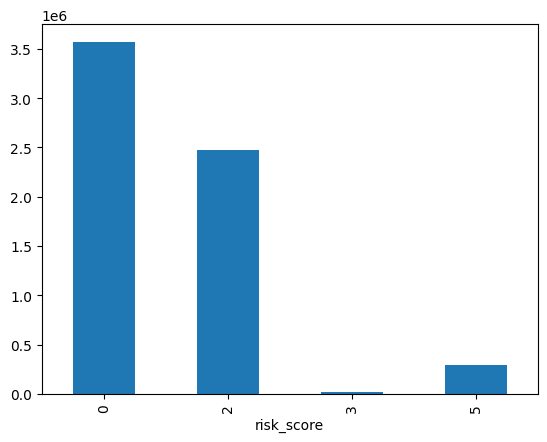

In [33]:
df_clean["risk_score"].value_counts().sort_index().plot(kind="bar")


<Axes: xlabel='risk_score'>

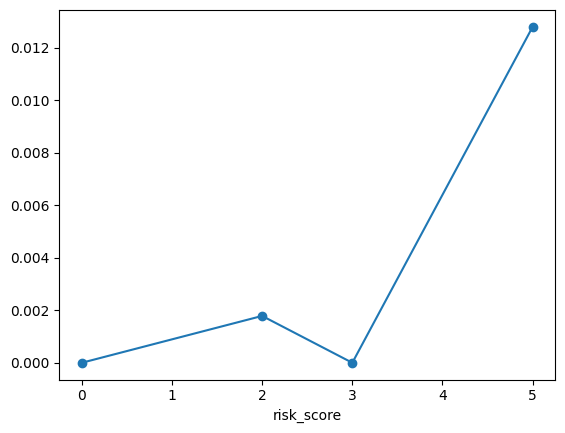

In [34]:
df_clean.groupby("risk_score")["is_fraud"].mean().plot(marker="o")


<Axes: ylabel='count'>

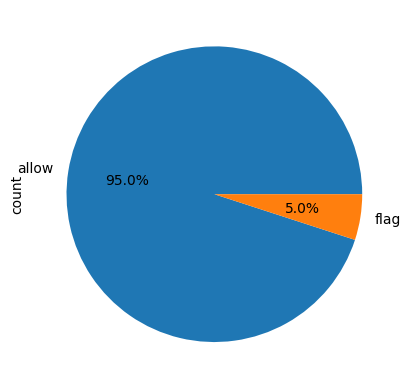

In [35]:
df_clean["risk_decision"].value_counts().plot(kind="pie", autopct="%1.1f%%")


In [36]:
import numpy as np
import pandas as pd

# Choose your operating threshold (we agreed 3)
RISK_THRESHOLD = 3

df_dash = df_clean.copy()

# Ensure risk_decision is based on the chosen threshold
df_dash["risk_decision"] = np.where(df_dash["risk_score"] >= RISK_THRESHOLD, "flag", "allow")

# Optional: create a "risk_band" for nicer visuals
df_dash["risk_band"] = pd.cut(
    df_dash["risk_score"],
    bins=[-1, 0, 2, 4, 10],
    labels=["None (0)", "Low (1-2)", "Medium (3-4)", "High (5+)"]
)

# Create a month/week-style time field from timestamp (PaySim step is not real date)
# We'll convert step to "day" and "week" to make trends possible
df_dash["day"] = (df_dash["timestamp"] // 24) + 1
df_dash["week"] = ((df_dash["day"] - 1) // 7) + 1

# Core KPI helper columns
df_dash["is_flagged"] = (df_dash["risk_decision"] == "flag").astype(int)
df_dash["is_fraud"] = df_dash["is_fraud"].astype(int)
df_dash["fraud_caught"] = ((df_dash["is_flagged"] == 1) & (df_dash["is_fraud"] == 1)).astype(int)
df_dash["false_positive"] = ((df_dash["is_flagged"] == 1) & (df_dash["is_fraud"] == 0)).astype(int)

# Keep only dashboard-friendly columns (you can add more later)
dashboard_cols = [
    "transaction_id",
    "timestamp", "day", "week",
    "amount", "currency",
    "transaction_type",
    "merchant_category",
    "country",
    "transaction_status",
    "risk_score", "risk_band",
    "risk_decision",
    "is_fraud",
    "fraud_caught",
    "false_positive",
    "high_value_flag",
    "velocity_flag",
    "merchant_risk_flag"
]

df_dash = df_dash[dashboard_cols]

df_dash.head()


,transaction_id,timestamp,day,week,amount,currency,transaction_type,merchant_category,country,transaction_status,risk_score,risk_band,risk_decision,is_fraud,fraud_caught,false_positive,high_value_flag,velocity_flag,merchant_risk_flag
0,1,1,1,1,9839.64,EUR,PAYMENT,retail,UK,approved,0,None (0),allow,0,0,0,False,False,False
1,2,1,1,1,1864.28,EUR,PAYMENT,retail,Germany,approved,0,None (0),allow,0,0,0,False,False,False
2,3,1,1,1,181.00,EUR,TRANSFER,peer_to_peer,UK,declined,2,Low (1-2),allow,1,0,0,False,False,True
3,4,1,1,1,181.00,EUR,CASH_OUT,atm,Netherlands,declined,2,Low (1-2),allow,1,0,0,False,False,True
4,5,1,1,1,11668.14,EUR,PAYMENT,retail,France,approved,0,None (0),allow,0,0,0,False,False,False


In [37]:
df_dash.to_csv("monitoring_view.csv", index=False)
print("Exported: monitoring_view.csv")


Exported: monitoring_view.csv


In [38]:
df_dash.shape
df_dash["risk_score"].value_counts().sort_index().head(10)


risk_score
0    3571433
2    2473056
3      20778
5     297353
Name: count, dtype: int64